# Exploratory data analysis

Identificar padrões de expressão gênica diferencial em amostras de transcriptoma de indivíduos com TEA, com foco em vias relacionadas à plasticidade sináptica e neuroinflamação, utilizando técnicas de bioinformática e machine learning

Instalar e importar bibliotecas

In [ ]:
!pip install numpy pandas seaborn matplotlib scanpy adjustText
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [ ]:
!pip install GEOparse

In [15]:
from google.colab import files

!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE102nnn/GSE102741/suppl/GSE102741_log2RPKMcounts.xlsx

--2025-04-03 12:44:04--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE102nnn/GSE102741/suppl/GSE102741_log2RPKMcounts.xlsx
           => ‘GSE102741_log2RPKMcounts.xlsx’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE102nnn/GSE102741/suppl ... done.
==> SIZE GSE102741_log2RPKMcounts.xlsx ... 28014606
==> PASV ... done.    ==> RETR GSE102741_log2RPKMcounts.xlsx ... done.
Length: 28014606 (27M) (unauthoritative)

GSE102741_log2RPKMc 100%[===================>]  26.72M  32.9MB/s    in 0.8s    

2025-04-03 12:44:05 (32.9 MB/s) - ‘GSE102741_log2RPKMcounts.xlsx’ saved [28014606]



In [16]:
# Carregar os dados de expressão (arquivo XLSX)
expr_data = pd.read_excel("GSE102741_log2RPKMcounts.xlsx", index_col=0)

# Verificar
print("Dimensões da matriz:", expr_data.shape)
print("\nPrimeiras linhas:\n", expr_data.iloc[:5,:5])

Dimensões da matriz: (57659, 52)

Primeiras linhas:
                  sample1  sample2  sample3  sample4  sample5
ENSG00000237375      0.0      0.0      0.0      0.0      0.0
ENSG00000238432      0.0      0.0      0.0      0.0      0.0
ENSG00000262510      0.0      0.0      0.0      0.0      0.0
ENSG00000262752      0.0      0.0      0.0      0.0      0.0
ENSG00000261847      0.0      0.0      0.0      0.0      0.0


In [23]:
# Extrair condições dos Sample_characteristics_ch1
conditions = []
for line in open("GSE102741_series_matrix.txt"):
    if line.startswith("!Sample_characteristics_ch1") and "disease status:" in line:
        parts = line.strip().split("\t")
        for part in parts[1:]:
            if "Healthy control" in part:
                conditions.append("control")
            elif "Autism spectrum disorder" in part:
                conditions.append("autism")

# Criar DataFrame de metadados
# Metadados (autismo vs controle)
metadata = pd.DataFrame({
    'sample_id': expr_data.columns,
    'condition': conditions[:len(expr_data.columns)]
})

PCA

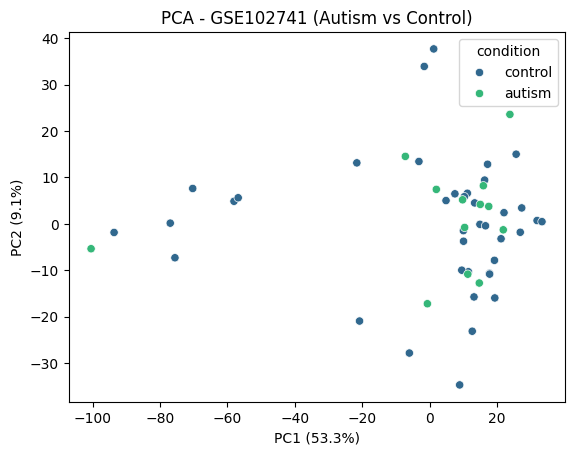

In [24]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expr_data.T)  # Transpor para amostras x genes

# Plot
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],
                hue=metadata['condition'], palette="viridis")
plt.title("PCA - GSE102741 (Autism vs Control)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.show()

Heatmap para genes variáveis

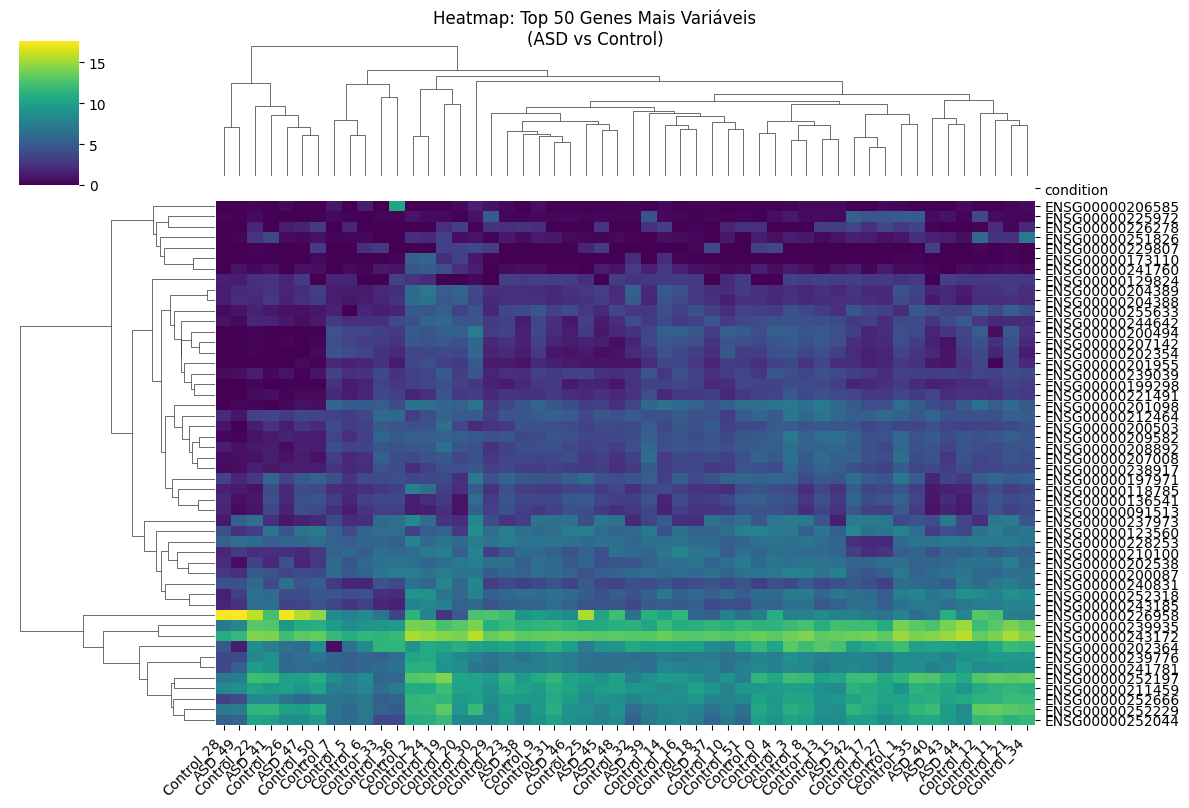

In [25]:
# Criar coluna 'sample_label' no metadata
metadata['sample_label'] = metadata.apply(
    lambda row: f"ASD_{row.name}" if row['condition'] == 'autism' else f"Control_{row.name}",
    axis=1
)

# Mapear cores para as condições (vermelho = ASD, azul = Control)
colors = metadata['condition'].map({'autism': 'red', 'control': 'blue'})

# Configurar o clustermap
g = sns.clustermap(
    heatmap_data,
    cmap='viridis',
    col_colors=colors,
    figsize=(12, 8),
    yticklabels=True,  # Mostrar nomes dos genes no eixo Y
    xticklabels=metadata['sample_label']  # Rótulos personalizados no eixo X
)

# Ajustar layout
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
g.fig.suptitle("Heatmap: Top 50 Genes Mais Variáveis\n(ASD vs Control)", y=1.02)
plt.show()

Verificando alinhamento dos dados

In [30]:
# Verifique se as amostras em metadata correspondem a expr_data
print("Amostras em metadata:", metadata['sample_id'].tolist()[:5])
print("Amostras em expr_data:", expr_data.columns.tolist()[:5])

# Verifique a correspondência de condições
print("\nDistribuição de condições:")
print(metadata['condition'].value_counts())

Amostras em metadata: ['sample1', 'sample2', 'sample3', 'sample4', 'sample5']
Amostras em expr_data: ['sample1', 'sample2', 'sample3', 'sample4', 'sample5']

Distribuição de condições:
condition
control    39
autism     13
Name: count, dtype: int64


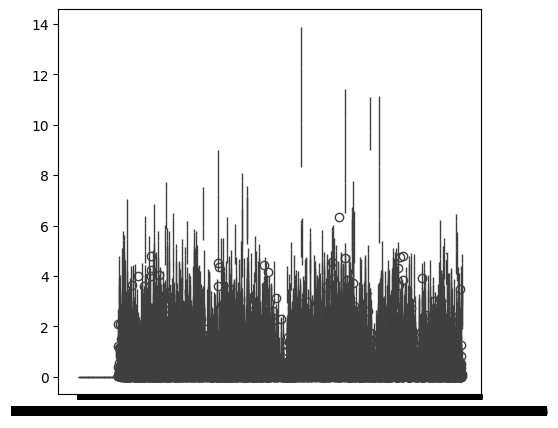

In [31]:
# Verifique a distribuição geral dos dados
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.boxplot(data=expr_data.iloc[:,:10].T)  # Primeiras 10 amostras
plt.title("Distribuição de Expressão (Amostras)")
plt.xticks(rotation=90)

plt.subplot(122)
sns.boxplot(data=expr_data.sample(100, axis=0))  # 100 genes aleatórios
plt.title("Distribuição de Expressão (Genes)")
plt.show()

Análise de Expressão Diferencial

Colunas em metadata: ['sample_id', 'condition', 'sample_label']

Primeiras amostras em expr_data: ['sample1', 'sample2', 'sample3', 'sample4', 'sample5']

Distribuição de condições:
condition
control    39
autism     13
Name: count, dtype: int64

Genes com diferença potencial: 1
                  gene       ttest_p          mw_p    log2FC  ttest_p_adj  \
14992  ENSG00000200959  2.017586e-07  3.153414e-07 -0.737972          NaN   

       mw_p_adj  
14992  0.018182  


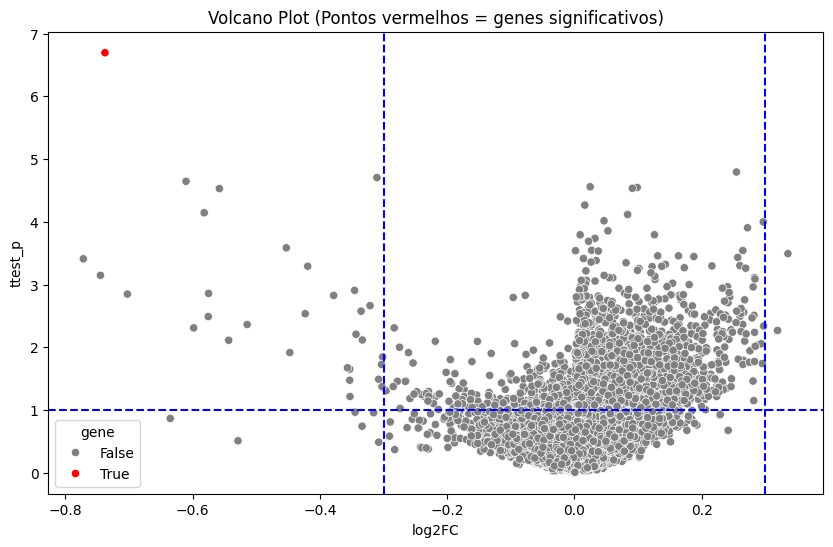

In [38]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests  # Importação corrigida

# Verificação da estrutura dos dados
print("Colunas em metadata:", metadata.columns.tolist())
print("\nPrimeiras amostras em expr_data:", expr_data.columns[:5].tolist())
print("\nDistribuição de condições:")
print(metadata['condition'].value_counts())

# Identificação da coluna de amostras
sample_id_column = 'sample_id'  # Confirmar que é o nome correto

# Separar grupos
autism_samples = metadata[metadata['condition'] == 'autism'][sample_id_column]
control_samples = metadata[metadata['condition'] == 'control'][sample_id_column]

# 1. Pré-processamento robusto
expr_matrix = expr_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# 2. Análise com múltiplos métodos
results = []
for gene in expr_matrix.index:
    try:
        autism_vals = expr_matrix.loc[gene, autism_samples].astype(float)
        control_vals = expr_matrix.loc[gene, control_samples].astype(float)

        # Teste t tradicional
        _, ttest_p = ttest_ind(autism_vals, control_vals, nan_policy='omit')

        # Teste não-paramétrico (Mann-Whitney)
        _, mw_p = mannwhitneyu(autism_vals, control_vals)

        # Cálculo de effect size
        log2fc = np.log2((np.nanmean(autism_vals)+1)) - np.log2((np.nanmean(control_vals)+1))

        results.append({
            'gene': gene,
            'ttest_p': ttest_p,
            'mw_p': mw_p,
            'log2FC': log2fc
        })
    except Exception as e:
        print(f"Erro no gene {gene}: {str(e)}")
        continue

results_df = pd.DataFrame(results)

# 3. Correção FDR usando multipletests
results_df['ttest_p_adj'] = multipletests(results_df['ttest_p'], method='fdr_bh')[1]
results_df['mw_p_adj'] = multipletests(results_df['mw_p'], method='fdr_bh')[1]

# 4. Seleção de genes significativos (critérios relaxados)
sig_genes = results_df[
    ((results_df['ttest_p_adj'] < 0.1) | (results_df['mw_p_adj'] < 0.1)) &
    (abs(results_df['log2FC']) > 0.3)
].sort_values('log2FC', ascending=False)

print(f"\nGenes com diferença potencial: {len(sig_genes)}")
if len(sig_genes) > 0:
    print(sig_genes.head())
else:
    print("Nenhum gene encontrado com os critérios atuais. Sugestões:")
    print("1. Relaxar critérios (aumentar p-valor ou reduzir log2FC)")
    print("2. Verificar normalização dos dados")
    print("3. Analisar possíveis batch effects")

# Visualização dos resultados
if len(sig_genes) > 0:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='log2FC', y=-np.log10(results_df['ttest_p']),
                    hue=results_df['gene'].isin(sig_genes['gene']),
                    palette={True: 'red', False: 'gray'})
    plt.axhline(-np.log10(0.1), linestyle='--', color='blue')
    plt.axvline(0.3, linestyle='--', color='blue')
    plt.axvline(-0.3, linestyle='--', color='blue')
    plt.title("Volcano Plot (Pontos vermelhos = genes significativos)")
    plt.show()

In [39]:
# Instale o pacote se necessário
!pip install mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.8 MB/s eta 0:00:00
SNORA74A small nucleolar RNA, H/ACA box 74A


In [40]:
from mygene import MyGeneInfo
mg = MyGeneInfo()

# Consulta para o gene encontrado
gene_info = mg.query('ENSG00000200959', species='human')
print(gene_info['hits'][0]['symbol'], gene_info['hits'][0]['name'])

SNORA74A small nucleolar RNA, H/ACA box 74A


Expressão diferencial entre grupos

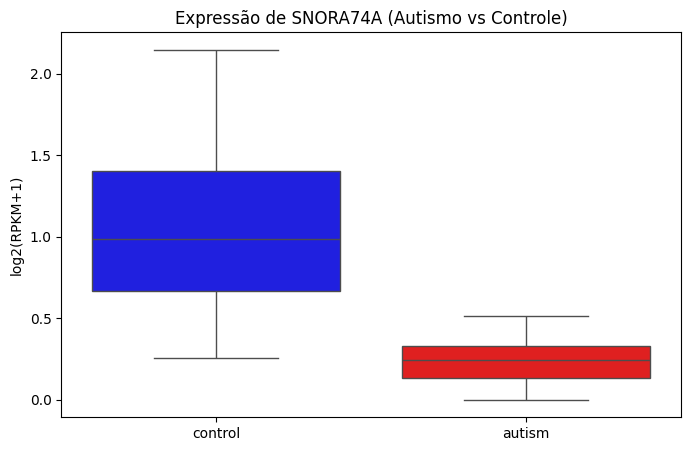

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dados para o plot
data = pd.DataFrame({
    'Expressão': expr_matrix.loc['ENSG00000200959'].values,
    'Grupo': metadata['condition']
})

# Boxplot corrigido
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=data,
    x='Grupo',
    y='Expressão',
    hue='Grupo',  # Adicionado
    palette={'autism': 'red', 'control': 'blue'},
    legend=False  # Remove a legenda redundante
)
plt.title("Expressão de SNORA74A (Autismo vs Controle)")
plt.ylabel("log2(RPKM+1)")
plt.xlabel("")  # Remove o rótulo duplicado
plt.show()